# Principle Component Analysis for Song-lyric Keywords

In this notebook, we demonstrate how we can use PCA for dimensionality reduction, which can be useful for visualizing word embeddings. We use a subset of topics that Miles found from a dataset of song lyrics, which our group (Section 2, Group 3) will use for the Final Project. We then calculate their embeddings and perform principle component analysis, before discussing the explained variance of our components. Lastly, we create the visualization of the words as they correspond to their original topics.

**Table of Contents**
1. [Data preprocessing and Calculating Word Embeddings](#data-preprocessing-and-calculating-word-embeddings)
2. [Principal Components and Explained Variance](#calculating-principal-components)
3. [Visualizing Words and Topics](#visualizing-words-and-topics)

**Authors: Jyontika and Audrey**

### Data preprocessing and Calculating Word Embeddings
Here are three of the topics that Miles identified from the dataset of song lyrics using LDA Topic Modeling. We will be using these as our data for this example.

In [81]:
topic_dict = {}
topic_dict['topic_0'] = ['heart', 'tonight', 'dream', 'love', 'dance', 'night', 'song', 'sweet', 'kiss', 'arms']
topic_dict['topic_1'] = ['god', 'lord', 'soul', 'heaven', 'jesus', 'born', 'king', 'earth', 'holy', 'world']
topic_dict['topic_2'] = ['life', 'world', 'live', 'die', 'like', 'end', 'lies', 'people', 'living', 'inside']

These three topics appear to correspond to distinct words, but note that 'world' appears in both `topic_1` and `topic_2`. For simplicity in this example, we assign 'world' to `topic_2`.

Let us find all unique keywords, and calculate their word embeddings using the Universal Sentence Encoder (which we used in Project 2). 

In [55]:
# Combine all lists of keywords into one list
all_keywords = []
for topic in topic_dict.values():
    all_keywords.extend(topic)

# Convert the list to a set to remove duplicates. 
unique_keywords = list(set(all_keywords))

print("Number of keywords: ", len(unique_keywords))

Number of keywords:  29


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Load the Universal Sentence Encoder's TF Hub module
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [56]:
# Calculate the embeddings
keywordEmbed = embed(unique_keywords)

### Calculating Principal Components

We then use PCA to reduce the dimensionality of our data. Recall that the Universal Sentence encoder returns vectors of dimension n=512.

* We do not need to standardize our data as all the embeddings are the are normalized to have unit norm. Therefore, the range of values for each dimension are already between -1 and 1.
* We use the `pca.fit_transform()` method from the PCA implementation in `sklearn.decomposition`. You can learn more about this method from the documentation linked [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [86]:
import pandas as pd
from sklearn.decomposition import PCA

pca = PCA(n_components=2)   # We want 2 principal components so that we can visualize our embeddings in 2D

# Fit the Principal Components
transformed_data = pca.fit_transform(keywordEmbed)

We can see what each Principal Component looks like in the following Dataframe.

In [ ]:
# Create a Dataframe with the words and corresponding PCs
principalDf = pd.DataFrame(data = transformed_data
             , columns = ['Principal Component 1', 'Principal Component 2'])
principalDf['Words'] = unique_keywords

# Map words to topics
word_to_topic = {}
for topic, words in topic_dict.items():
    for word in words:
        word_to_topic[word] = topic

# Create a list of topics for each word
topics = [word_to_topic[word] for word in unique_keywords]

# Add the 'Topic' column
principalDf['Topic'] = topics

In [90]:
principalDf.head()

,Principal Component 1,Principal Component 2,Words,Topic
0,0.181368,-0.225071,earth,topic_1
1,0.432504,-0.095256,live,topic_2
2,0.361407,0.213684,die,topic_2
3,0.068484,0.146056,lies,topic_2
4,-0.109479,0.275085,arms,topic_0


We may also want to inspect the **Explained Variance** of our model, which tells us how much information (variance) can be attributed to each of the principal components. These are also known as the eigenvalues, which represent the variance in the direction of the corresponding eigenvectors.

This is important because when we reduce the high-dimensional space our word embeddings to a two-dimensional space, we lose some of the variance (or information). We can do this using the attribute `explained_variance_ratio_`.

In [82]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio for Principal Component 1:", explained_variance_ratio[0])
print("Explained Variance Ratio for Principal Component 2:", explained_variance_ratio[1])

Explained Variance Ratio for Principal Component 1: 0.09165317460970537
Explained Variance Ratio for Principal Component 2: 0.0826962392749292


Here, you can see that the first principal component contains 9.17% of the variance, and the second principal component contains 8.27% of the variance. Together, the two components only contain 17.44% of the original information. Ideally, we would want this number to be high, so this is a limitation of reducing our dimensions from 512 to 2.

### Visualizing Words and Topics
Now, let us visualize our words based on their principal components. We assign each topic a color and label each point with its word.

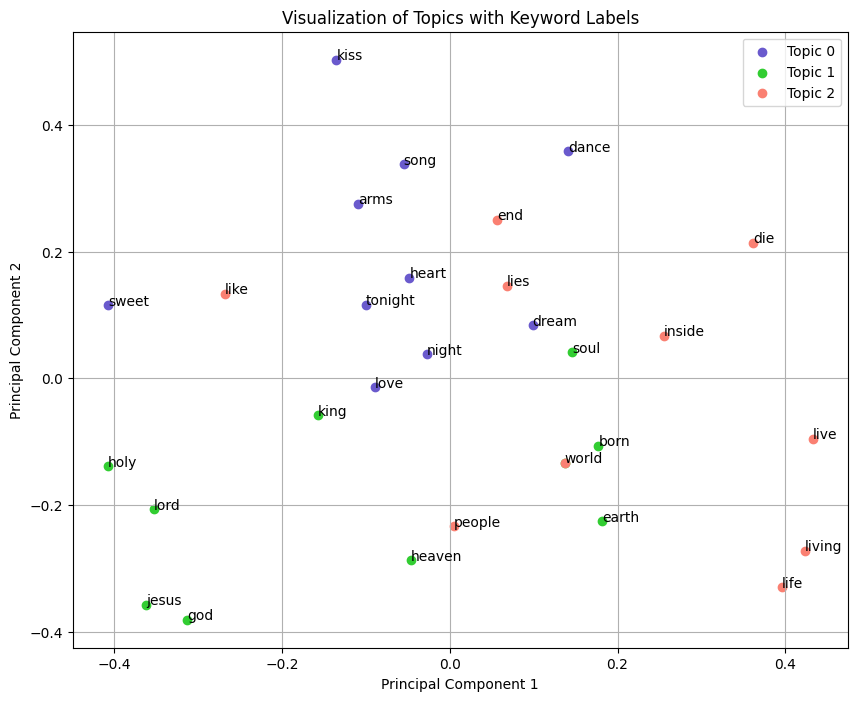

In [94]:
import matplotlib.pyplot as plt

# Define colors for each topic
colors = ['slateblue', 'limegreen', 'salmon']

# Create a scatter plot
plt.figure(figsize=(10, 8))
for i, topic in enumerate(topic_dict.values()):
    # Get the indices of keywords in each topic
    indices = [unique_keywords.index(word) for word in topic]
    # Plot the points for this topic. This is so we can assign colors for each topic.
    plt.scatter(principalComponents[indices, 0], principalComponents[indices, 1], color=colors[i], label=f'Topic {i}')

# Annotate each point with its corresponding word
for i, word in enumerate(unique_keywords):
    plt.annotate(word, (principalComponents[i, 0], principalComponents[i, 1]))

# Now, we can plot our data
plt.title('Visualization of Topics with Keyword Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.grid(True)
plt.show()


From this plot, we can see that the topics do not correspond to clear clusters (as we may have seen in previous examples for clustering and TSNE visualizations). This is largely due to the small explained variance of our principal components. Nevertheless, this visualization closely mirrors what we would expect to see - with religion-connoted words like "holy," "lord," "jesus," and "god" on one side, and semantically-similar words like "life," "living," and "life" on the other. "world" also falls somewhere between the words from `topic_1` and `topic_2`, which is what we anticipate.  

# OLD CODE

In [53]:
#df.from_dict(topic_dict)

,topic_0,topic_1,topic_2
0,heart,god,life
1,tonight,lord,world
2,dream,soul,live
3,love,heaven,die
4,dance,jesus,like
5,night,born,end
6,song,king,lies
7,sweet,earth,people
8,kiss,holy,living
9,arms,world,inside


In [19]:
df = pd.read_json('video_keywords.json')

In [20]:
df

,video_id,video_keywords
0,7273221955937914155,"[angels, tibet, angels, tibet, dance, angels, ..."
1,7285397643725983008,"[dream, academy, angels, tibet, adela, dream, ..."
2,7309159185550183723,"[flights, people, amazon, student, prime, holi..."
3,7308541182819175722,"[replying, emily, today, making, diy, ornament..."
4,7307649122918567211,"[nattie, christmas, tree, sad, baby, beige, st..."
...,...,...
13546,7286461444554624299,"[university, pittsburgh, assignment, universit..."
13547,7285527057394584863,"[might, new, theyve, grinding, long, time, inc..."
13548,7284024264334806315,"[chipotle, chipotle, burrito, chipotle, life, ..."
13549,7284462467290303787,"[could, make, way, cuter, video, hiding, face,..."


In [16]:
df

,video_id,video_keywords
0,7273221955937914155,"['angels', 'tibet', 'angels', 'tibet', 'dance'..."
1,7285397643725983008,"['dream', 'academy', 'angels', 'tibet', 'adela..."
2,7309159185550183723,"['flights', 'people', 'amazon', 'student', 'pr..."
3,7308541182819175722,"['replying', 'emily', 'today', 'making', 'diy'..."
4,7307649122918567211,"['nattie', 'christmas', 'tree', 'sad', 'baby',..."
...,...,...
13546,7286461444554624299,"['university', 'pittsburgh', 'assignment', 'un..."
13547,7285527057394584863,"['might', 'new', 'theyve', 'grinding', 'long',..."
13548,7284024264334806315,"['chipotle', 'chipotle', 'burrito', 'chipotle'..."
13549,7284462467290303787,"['could', 'make', 'way', 'cuter', 'video', 'hi..."


In [23]:
all_keywords = [keyword for sublist in df['video_keywords'] for keyword in sublist]
unique_keywords = list(set(all_keywords))
len(unique_keywords)

43198

In [24]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Load the Universal Sentence Encoder's TF Hub module
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [25]:
keywordEmbed = embed(unique_keywords)

In [26]:
import numpy as np
from sklearn.decomposition import PCA

In [49]:
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(keywordEmbed)

In [43]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

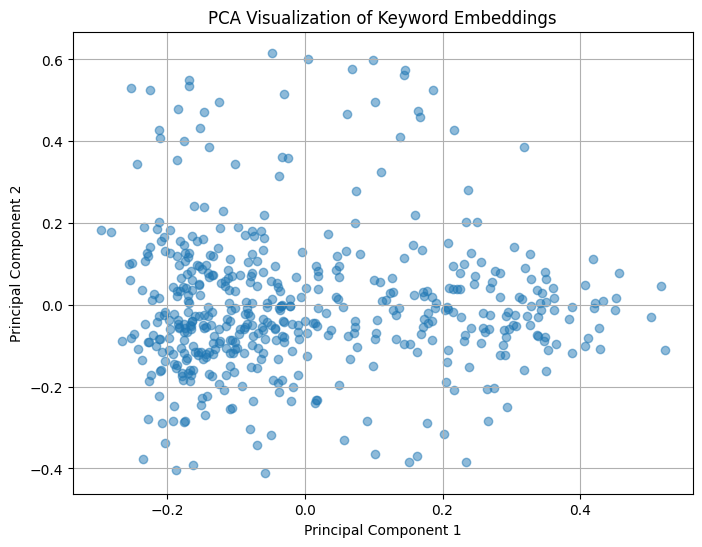

In [50]:
plt.figure(figsize=(8, 6))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5)
plt.title('PCA Visualization of Keyword Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show

In [48]:
df['sentence'] = df['video_keywords'].apply(lambda x: ' '.join(x))

keywordEmbed = embed(df['sentence'].head(500))

In [2]:
# get the news hashtags
import json
news = json.load(open('news-hashtags.json'))
news[:10]

['economy',
 'constitution',
 'breakingnews',
 'noticias',
 'scotus',
 'mediawatch',
 'historytok',
 'liberal',
 'crime',
 'conservative']

In [3]:
# remember that we loaded the model in the prior section
newsEmbed = embed(news)
newsEmbed.shape


TensorShape([129, 512])

In [7]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(newsEmbed)

clusters[:10]

array([2, 0, 1, 2, 0, 2, 2, 0, 2, 0], dtype=int32)

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)  
tsne_results = tsne.fit_transform(newsEmbed)

In [8]:
import pandas as pd

df = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
df['hashtag'] = news  
df['cluster'] = clusters # the cluster indices where each news hashtags belong
df.head()

,tsne_1,tsne_2,hashtag,cluster
0,-4.127779,3.591462,economy,2
1,0.491287,4.877659,constitution,0
2,0.130666,-2.651469,breakingnews,1
3,1.710194,10.082147,noticias,2
4,0.559678,5.412064,scotus,0


In [9]:
import plotly.express as px

# Create the scatter plot
fig = px.scatter(df, x='tsne_1', y='tsne_2', text='hashtag', color="cluster", color_continuous_scale="BlueRed")

# Format what to show next to the markers
fig.update_traces(textposition='top center', 
                  mode='markers+text', 
                  textfont=dict(size=6))

fig.update_layout(title='Embeddings of TikTok News Hashtags', width=800, height=800)
fig.show()